# Image classification using CNN

## Load packages

In [31]:
import time
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
np.random.seed(2017) 

#Keras, deep learning libraries
from keras.models import Sequential, load_model
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import backend as K
from keras.datasets import cifar10
import os
import tensorflow as tf
from tensorflow.python.client import device_lib

import pickle
import pandas as pd
from skimage import io
from scipy import misc
import skimage.transform as st
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import h5py
from flask import Flask, request, render_template
from keras.preprocessing.image import ImageDataGenerator

Populating the interactive namespace from numpy and matplotlib


## Download and load Cifar-10 dataset

In [32]:
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()

In [33]:
num_train, img_channels, img_rows, img_cols = train_features.shape
num_test, _, _, _ = test_features.shape
num_classes = len(np.unique(train_labels))

In [34]:
print(num_classes) #<- number of classes
print(train_features.shape) #<- training data shape
print(test_features.shape) #<- testing data shape

10
(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [35]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
              'ship', 'truck']

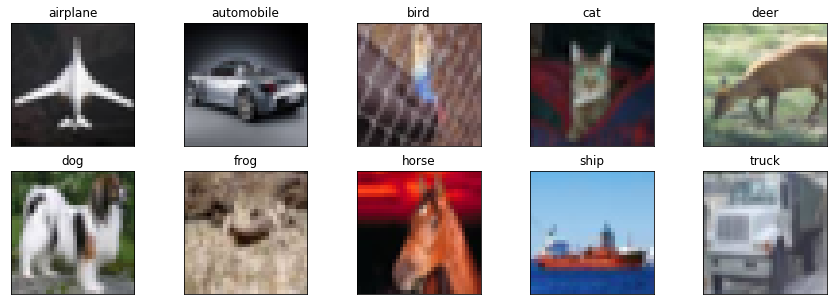

In [36]:
fig = plt.figure(figsize = (15,5))

for i in range(num_classes):
    ax = fig.add_subplot(2,5, 1+i, xticks = [], yticks = [])
    
    #Get first image row id for each class
    idx = np.where(train_labels[:]==i)[0]
    
    # Get features of the 1st image for each class
    features_idx = train_features[idx, ::]
    
    # Transpose and plot
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num, ::]
    ax.set_title(class_names[i])
    plt.imshow(im)
    
plt.show()

## Preprocessing

In [37]:
# Normalize
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255

In [38]:
# One hot encoding
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [39]:
# Function to plot accuracy and loss
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [40]:
# Function to compute test accuracy
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

## Compile CNN

In [41]:
# Define model

# Initialize model
model = Sequential()

# Step 1: Convolution
model.add(Conv2D(48, (3,3), padding = 'same', input_shape = (32,32,3), activation = 'relu'))

# Step 2: Pooling
model.add(MaxPooling2D(pool_size=(2,2)))

# Step 3: Flattening
model.add(Flatten())

# Step 4: Full connection
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dense(num_classes, activation = 'softmax'))

# Step 5: Compile model
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [42]:
train_models_flags = 0

In [44]:
if train_models_flags == 1:
    # Train the model
    model_info = model.fit(train_features, train_labels, batch_size = 128, epochs = 10, 
                          validation_data = (test_features, test_labels),
                          verbose = 1)

    model.save('saved_models/model.h5')
    
else:
    # Load the model
    saved_model = 'saved_models/model.h5'
    model = load_model(saved_model)

In [45]:
if train_models_flags == 1:
    plot_model_history(model_info)
    print("Accuracy on test data {}".format(accuracy(test_features, test_labels, model)))

## Hyperparameter tuning

In [46]:
# Define model

# Initialize model
model = Sequential()

# Stacked Convolution layer
model.add(Conv2D(48, (3,3), padding = 'same', input_shape = (32,32,3), activation = 'relu'))
model.add(Conv2D(48, (3,3), activation = 'relu'))

# Max pooling layer
model.add(MaxPooling2D(pool_size = (2,2)))

# Dropout for regularization
model.add(Dropout(0.25))

# Stacked convolution layer
model.add(Conv2D(96, (3,3), padding = 'same', activation = 'relu'))

model.add(Conv2D(96, (3,3), activation = 'relu'))

# Max pooling layer
model.add(MaxPooling2D(pool_size=(2,2)))

# Dropout for regularization
model.add(Dropout(rate = 0.25))

# Stacked Convolution layer
model.add(Conv2D(192, (3,3), padding = 'same', activation = 'relu'))
model.add(Conv2D(192, (3,3), activation = 'relu'))

# Max Pooling layer
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Dropout(rate = 0.25))

# Flattening
model.add(Flatten())

# Fully connected layer
model.add(Dense(units = 512, activation = 'relu'))

# Drop out for regularization
model.add(Dropout(rate = 0.25))

# Fully connected layer
model.add(Dense(units = 256, activation = 'relu'))

# Dropout for regularization
model.add(Dropout(rate = 0.25))

# Output fully connected layer
model.add(Dense(num_classes, activation = 'softmax'))

# Compile the model
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [47]:
train_models_flags = 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 332s 7ms/step - loss: 1.7332 - acc: 0.3480 - val_loss: 1.3622 - val_acc: 0.4995
Epoch 2/30
50000/50000 [==============================] - 318s 6ms/step - loss: 1.2755 - acc: 0.5416 - val_loss: 1.1597 - val_acc: 0.5972
Epoch 3/30
50000/50000 [==============================] - 308s 6ms/step - loss: 1.0882 - acc: 0.6151 - val_loss: 1.0049 - val_acc: 0.6415
Epoch 4/30
50000/50000 [==============================] - 298s 6ms/step - loss: 0.9611 - acc: 0.6633 - val_loss: 0.8340 - val_acc: 0.7103
Epoch 5/30
50000/50000 [==============================] - 1633s 33ms/step - loss: 0.8688 - acc: 0.6991 - val_loss: 0.7554 - val_acc: 0.7412
Epoch 6/30
50000/50000 [==============================] - 324s 6ms/step - loss: 0.7982 - acc: 0.7241 - val_loss: 0.7083 - val_acc: 0.7615
Epoch 7/30
50000/50000 [==============================] - 356s 7ms/step - loss: 0.7529 - acc: 0.7409 - val_loss: 0.7213 

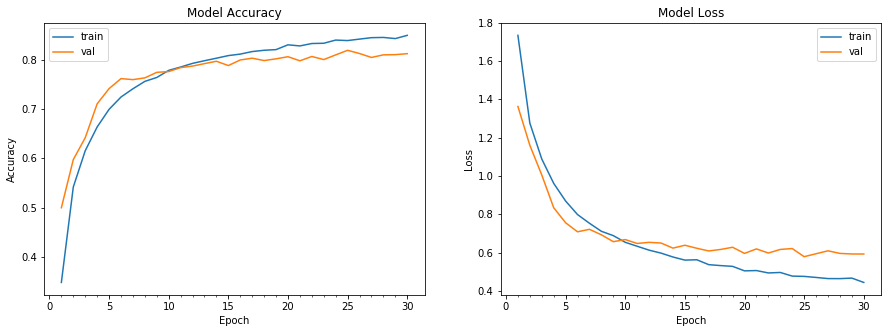

Accuracy on test data post hyperparameter tuning: 81.21000000000001


In [48]:
if train_models_flags == 1:
    
    # Train the model
    model_info = model.fit(train_features, train_labels,
                          batch_size = 64, epochs = 30,
                          validation_data = (test_features, test_labels),
                          verbose = 1)
    
    model.save('saved_models/tuned_model_fin.h5')
    
    plot_model_history(model_info)
    
else:
    
    saved_model = 'saved_models/tuned_model_fin.h5'
    model = load_model(saved_model)
    
    
print("Accuracy on test data post hyperparameter tuning: {}".format(accuracy(test_features, test_labels, model)))

## Data Augmentation

In [49]:
from keras.preprocessing.image import ImageDataGenerator

#Load Model
saved_model = 'saved_models/tuned_model_fin.h5'
loaded_model = load_model(saved_model)

datagen = ImageDataGenerator(
    rotation_range=10.,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=.2,
    horizontal_flip=True,
    vertical_flip=True)

In [ ]:
if train_models_flag == 1:
    # train the model
    start = time.time()
    # Train the model
    model_info = loaded_model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                     steps_per_epoch = train_features.shape[0]/128, epochs = 30, 
                                     validation_data = (test_features, test_labels), verbose=1)
    end = time.time()
    loaded_model.save("saved_models/tuned_model_aug.h5")
    #print ("Model took %0.2f seconds to train",(end - start))
    # plot model history
    plot_model_history(model_info)
    
# compute test accuracy
print ("Accuracy on test data post data augmentation is: ",accuracy(test_features, test_labels, loaded_model))
